# Load dataset

In [1]:
import pandas as pd
import mat73
import numpy as np

mat = mat73.loadmat('http.mat')

m, n = mat['X'].shape

d = dict()
d['y'] = mat['y'].astype(int)

for i in range(0, n):
    d['x{}'.format(i)] = mat['X'][:,i]

print('There are {} training examples and {} features'.format(m, n))

df = pd.DataFrame.from_dict(d)

y = df['y']
X = df.drop(columns='y')

X.head()

There are 567498 training examples and 3 features


,x0,x1,x2
0,-2.302585,5.371103,10.716107
1,-2.302585,5.088213,8.418058
2,-2.302585,5.464255,7.113224
3,-2.302585,5.451468,7.616825
4,-2.302585,5.476882,6.186414


# Explore data

array([[<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x1'}>],
       [<AxesSubplot:title={'center':'x2'}>, <AxesSubplot:>]],
      dtype=object)

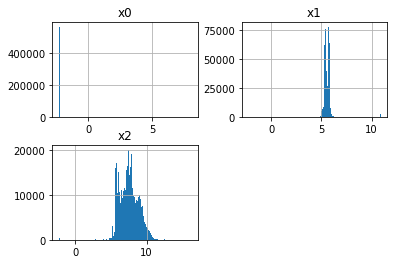

In [2]:
X.hist(bins=200)

Apart from x0, the features already look pretty Gaussian so no transformations required. x0 should be removed as it's basically just one number all the time.

# Preprocess
Let's remove x0 as this helps improve the performance a lot

In [3]:
def preprocess(X):
    X = X.drop(columns=['x0'])
    return X

X = preprocess(X)

# Split into Train, Cross Validation and Test

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate Mean and Variance

In [5]:
mu = X.mean()
var = X.var()

print('Mean: {}\n'.format(mu))
print('Variance: {}'.format(var))

Mean: x1    5.557679
x2    7.489226
dtype: float64

Variance: x1    0.189231
x2    1.734444
dtype: float64


# Predict Cross Validation set

In [6]:
def probability(x, mu, var):
    denom = np.sqrt(2*np.pi*var)
    
    num = np.exp((-np.power(x-mu,2)/(2*var)))
    p = num/denom
    
    return p.prod(axis=1)

p_cv = probability(X_cv, mu, var)

# Learn Epsilon

In [7]:
import math
import sklearn.metrics as metrics

best_F1 = 0
best_e = 1

print('Learning Epsilon, this may take a minute...')

for e in np.linspace(min(p_cv), max(p_cv), 2000):
  
    preds_cv = (p_cv < e).astype(int)

    F1 = metrics.f1_score(y_cv, preds_cv)
    
    if F1 > best_F1:
        best_F1 = F1
        best_e = e

print('Best epsilon threshold was {}, with F1 score of {}'.format(best_e, best_F1))


Learning Epsilon, this may take a minute...
Best epsilon threshold was 0.000138965323353796, with F1 score of 0.8934010152284264


# Test set

In [8]:
from sklearn.metrics import classification_report

p = probability(X_test, mu, var)
preds_test = (p < best_e).astype(int)

print(classification_report(y_test, preds_test))

precision    recall  f1-score   support

           0       1.00      1.00      1.00    113055
           1       0.79      1.00      0.88       445

    accuracy                           1.00    113500
   macro avg       0.90      1.00      0.94    113500
weighted avg       1.00      1.00      1.00    113500

